In [8]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import least_squares

In [9]:
def mag_err(mag, maglim, a=4.56, b=1, k=1, sigdet=5, zp=22.5): 
    """ 
    Compute the magnitude error as a function of a given detection limit 
    following Rykoff et al. (2015). 
    
    Parameters 
    ---------- 
    mag : float or `~numpy.ndarray` 
        Target magnitude. 
    maglim : float 
        Magnitude limit. 
    sigdet : float, optional 
        The `sigdet`-sigma detection limit used for `maglim`. Default is `5.`. 
    params : tuple of shape (3,), optional 
        Free parameters `(a, b, k)` used in the functional form given by 
        Rykoff et al. (2015). Default is `(4.56, 1., 1.)`. 
    
    Returns 
    ------- 
    magerr : float or `~numpy.ndarray` 
        Corresponding magnitude error. 
    """ 

    # Set parameters. 
    # a, b, k = params 
    teff = np.exp(a + b * (maglim - 21.)) 

    # Compute flux/limit. 
    F = 10**(-0.4 * (mag - zp)) 
    Flim = 10**(-0.4 * (maglim - zp)) 

    # Compute noise. 
    Fnoise = (Flim / sigdet)**2 * k * teff - Flim 
    magerr = 2.5 / np.log(10.) * np.sqrt((1. + Fnoise / F) / (F * k * teff)) 

    return magerr  

In [10]:
def model2(theta, mag, y, zp=22.5, sigdet=5, k=1):
    a, b, maglim = theta 
    teff = np.exp(a + b * (maglim - 21.)) 

    # Compute flux/limit. 
    F = 10**(-0.4 * (mag - zp)) 
    Flim = 10**(-0.4 * (maglim - zp)) 

    # Compute noise. 
    Fnoise = (Flim / sigdet)**2 * k * teff - Flim
    magerr = 2.5 / np.log(10.) * np.sqrt((1. + Fnoise / F) / (F * k * teff))

    return np.sum(np.abs(y - magerr))
    #return magerr - y

def model3(theta, mag, y, a=4.56, b=1, zp=22.5, sigdet=5, k=1):
    maglim = theta 
    teff = np.exp(a + b * (maglim - 21.)) 

    # Compute flux/limit. 
    F = 10**(-0.4 * (mag - zp)) 
    Flim = 10**(-0.4 * (maglim - zp)) 

    # Compute noise. 
    Fnoise = (Flim / sigdet)**2 * k * teff - Flim
    magerr = 2.5 / np.log(10.) * np.sqrt((1. + Fnoise / F) / (F * k * teff))

    return -np.sum(np.abs(y - magerr))
    #return magerr - y

def model4(theta, mag, y, zp=22.5, sigdet=5, k=1):
    teff, maglim = theta 
    #teff = np.exp(a + b * (maglim - 21.)) 

    # Compute flux/limit. 
    F = 10**(-0.4 * (mag - zp)) 
    Flim = 10**(-0.4 * (maglim - zp)) 

    # Compute noise. 
    Fnoise = (Flim / sigdet)**2 * k * teff - Flim
    magerr = 2.5 / np.log(10.) * np.sqrt((1. + Fnoise / F) / (F * k * teff))

    #return -np.sum(np.abs(y - magerr))
    return magerr - y

In [12]:
cat = Table.read('./test/PSZ2_G237.68+57.83_SDSS_catalog.csv')
cat = cat[cat['type'] == 3]

FileNotFoundError: [Errno 2] No such file or directory: './test/PSZ2_G237.68+57.83_SDSS_catalog.csv'

In [5]:
plt.scatter(cat['fiberMag_i'], cat['fiberMagErr_i'])
plt.ylim(-0.01, 1)
mags = np.linspace(12, 25, 50)
mags_err = mag_err(mags, 22.2)
plt.plot(mags, mags_err, c='k')
plt.xlabel('mags')
plt.ylabel('mags err')
plt.savefig('magsvserror.png', bbox='tight')

NameError: name 'cat' is not defined

In [6]:
band = 'i'
result = least_squares(model2, (4, 1, 20), loss='cauchy', f_scale=np.std(cat[f'fiberMagErr_{band}']),
                       args=(cat[f'fiberMag_{band}'], cat[f'fiberMagErr_{band}']), 
                       bounds=([3,0.5, 18], [5,2, 25]))
print(result)

NameError: name 'cat' is not defined

In [7]:
plt.scatter(cat[f'fiberMag_{band}'], cat[f'fiberMagErr_{band}'])
plt.ylim(-0.01, 1)
mags = np.linspace(12, 25, 50)
mags_err = mag_err(mags, result['x'][2], a=result['x'][0], b=result['x'][1])
plt.plot(mags, mags_err, c='k')

NameError: name 'cat' is not defined

In [13]:
psz = Table.read('./test/PSZ2_G022.03+17.75i_cal.cat', format='ascii')

FileNotFoundError: [Errno 2] No such file or directory: './test/PSZ2_G022.03+17.75i_cal.cat'

In [11]:
# filter out non-detections
psz = psz[psz['MAG_AUTO'] < 30]

In [40]:
result = least_squares(model2, (4, 1, 20), loss='cauchy', f_scale=np.std(psz['MAGERR_AUTO']),
                       args=(psz['MAG_AUTO'], psz['MAGERR_AUTO']), kwargs={'zp':27.7105, 'sigdet':3}, 
                       bounds=([3,0.5, 15], [5,2, 30]))
print(result)

 active_mask: array([0, 0, 0])
        cost: 500.0659032524535
         fun: array([6795.03638914])
        grad: array([0.02647743, 0.00551543, 0.07408338])
         jac: array([[3.57324098e-08, 7.44330464e-09, 9.99786474e-08]])
     message: '`ftol` termination condition is satisfied.'
        nfev: 22
        njev: 13
  optimality: 0.4599316228211219
      status: 2
     success: True
           x: array([ 3.96470185,  0.88544238, 21.20829696])


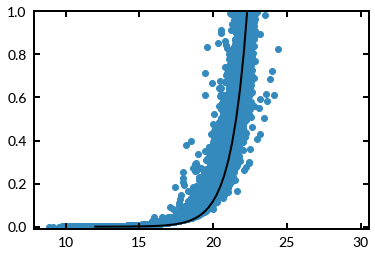

In [41]:
plt.scatter(psz['MAG_AUTO'], psz['MAGERR_AUTO'])
plt.ylim(-0.01, 1)
mags = np.linspace(12, 25, 50)
mags_err = mag_err(mags, result['x'][2], a=result['x'][0], b=result['x'][1], sigdet=3, zp=27.7105)
#mags_err = mag_err(mags, 26, a=4.56, b=1, zp=27.7105, sigdet=3)
plt.plot(mags, mags_err, c='k')